# The Imports for the pipeline

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup

from lxml import html
import math
import pandas as pd
import json

from multiprocessing.pool import Pool
from extract_functions import get_titles_and_abstracts # External python file I made, it should also be included with this code
from functools import partial
import time

import nltk
from nltk import FreqDist
nltk.download('punkt')

import glob
import re

from langdetect import detect
from chemdataextractor import Document 
from chemdataextractor.doc import Paragraph

import pytrends
from pytrends.request import TrendReq

import matplotlib.pyplot as plt

# Webscraping PubMed

In [0]:
# Instantiation of the path and the location of the chromedriver (Set this to the paths of your machine)
directory = "D:/Jupyter_Projects/Jupyter Notebooks/Textmining/Project"
chromedriver = "D:/Jupyter_Projects/Jupyter Notebooks/Textmining/Project/chromedriver.exe"

# I had set my configuration to false here, because I would not have been able to write to a file
headless = False

# Configuring the selenium webdriver
chromeOptions = webdriver.ChromeOptions()
prefs = {"download.default_directory" : directory}
chromeOptions.add_experimental_option("prefs",prefs)
chromeOptions.add_argument("--disable-extensions")
if headless:
    chromeOptions.add_argument('--headless')
    chromeOptions.add_argument('--no-sandbox') # Headless can give errors, which are fixed with this but this also takes away the ability to write to a file somehow (only chrome has sandbox)
driver = webdriver.Chrome(executable_path=chromedriver, chrome_options=chromeOptions)

# Accessing pubmed with a given query to know what the amount of results is for the query, this helps us to estimate the amount of pages required for the webscraping
driver.get('https://www.ncbi.nlm.nih.gov/pubmed/?term="Covid19"%20AND%20"treatment"')
soup = BeautifulSoup(driver.page_source, "html.parser")
amount_of_results = int(soup.findAll("div", {"class": "results-amount"})[0].text.replace('\n', '').replace('results', '').replace(',','').strip()) 
amount_of_pages = int(math.ceil(amount_of_results / 200))
# Sites like pubmed have a maximum of allowed results to look through, which is in this case 10000 (50 * 200)
# I could not manage to bypass this
if amount_of_pages > 50:
    amount_of_pages = 50
driver.quit() # Quit the driver and close chrome

# Creating json files for the abstracts and titles, and csv files for the pubmed IDs
for i in range(amount_of_pages):
    json_file = open("abstracts_{0}.json".format(i + 1),"w+")
    json_file.close()
    csv_file = open('pubmedIDs_{0}.csv'.format(i + 1),'w+')
    csv_file.close()

# All urls and their pagenumbers
urls = ['https://www.ncbi.nlm.nih.gov/pubmed/?term="Covid19"%20AND%20"treatment"&format=abstract&size=200'] + ['https://www.ncbi.nlm.nih.gov/pubmed/?term="Covid19"%20AND%20"treatment"&format=abstract&size=200&page={0}'.format(count + 1) for count in range(amount_of_pages)[1:]]
counts = [i + 1 for i in range(len(urls))]

# A multiprocessing pool with amount_of_pages threads
def split_into_chunks(list_input, n):
    k, m = divmod(len(list_input), n)
    return (list_input[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

# Change this number to account for your processor, mine cannot handle all pages at once (your screen will become black) 
amount_of_chunks = 20

# Making chunks of the lists of urls and pagenumbers
url_chunks = list(split_into_chunks(urls, amount_of_chunks))
count_chunks = list(split_into_chunks(counts, amount_of_chunks))

# Spawning a subprocess for every chunk, each subprocess is tasked with retrieving titles and abstracts from a results page
# I also added 60 seconds for my processor to recover after each chunk
for count, url in zip(count_chunks, url_chunks):
    pool = Pool(processes=len(count_chunks))
    pool.map(partial(get_titles_and_abstracts), zip(url, count))
    time.sleep(60)

# Combining the files into one json file and one csv file

In [ ]:
# Combining the json files and the csv files into one json file and one csv file

read_files = glob.glob("saved_data/*.json")
read_files.sort(key=lambda f: int(re.sub('\D', '', f))) # Sort by number
with open("abstracts.json", "w") as outfile:
    outfile.write('[{}]'.format(
        ','.join([open(f, "r").read() for f in read_files])))
    
read_files = glob.glob("saved_data/*.csv")
read_files.sort(key=lambda f: int(re.sub('\D', '', f)))
with open("pubmedIDs.csv", "w") as outfile:
    outfile.write('[{}]'.format(
        ','.join([open(f, "r").read() for f in read_files])))

# Preprocessing pubmed IDs

In [ ]:
# Preprocessing the csv file with pubmed IDs

count = 0
with open("pubmedIDs.csv", "r+") as csv_file: 
    contents = ''
    for row in csv_file.readlines():
        if row[:3] == 'PMC': # PMC IDs are new at pubmed, but pubmedIDs are enough
            pass
        else:
            new_row = row.replace("[", "").replace("]","").replace(",", "") # These are the only occuring problems with the csv
            if count % 2 == 0: # Drop all rows with even indices, because all IDs appear twice
                contents += new_row
            count += 1
            
    csv_file.seek(0)
    csv_file.write(contents)
    csv_file.truncate()

# Preprocessing abstract entries

In [ ]:
# Preprocessing the abstract entries in the json file

with open('abstracts.json', 'r+') as json_file:
    data = json.load(json_file)
    
    titles,abstracts = [],[]
    for page in data:
        for result in page["titles"]:
            titles.append(result)
        for result in page["abstracts"]:
            if not 'Plain Language Summary' in result: # There are 7 mentions of so-called Plain Language Summaries, but I do not have time for a workaround
                abstracts.append(result)
            
    abstract_df = pd.DataFrame.from_records([abstracts, titles]).T # Making a dataframe from the lists
    abstract_df.columns = ['abstracts', 'titles'] # Column names
    abstract_df = abstract_df[~abstract_df['abstracts'].str.contains('No abstract available')] # Drop rows where there is no abstract available
    abstract_df = abstract_df.reset_index(drop=True) # Reset the indices
    
abstract_df

,abstracts,titles
0,Abstract The COVID-19 pan...,Similarities between the effect of SARS-CoV-2 ...
1,Abstract The impact of th...,The Impact of COVID-19 on HIV Treatment and Re...
2,Abstract Objective: ...,Efficacy of chloroquine and hydroxychloroquine...
3,Abstract A novel coronavi...,Hydroxychloroquine and chloroquine: a potentia...
4,Abstract Coronavirus dise...,COVID-19: Learning from Lessons To Guide Treat...
...,...,...
9232,Abstract Background: ...,The shifting preferences of patients and physi...
9233,Abstract The outbreak of ...,Treatment Armamentarium of COVID-19: Evolving ...
9234,Abstract Purpose: ...,Urologic oncology practice during COVID-19 pan...
9235,Abstract The sudden pande...,Expert Consensus for Treating Cancer Patients ...


# Preprocessing continued: putting the entities into one json file and counting the occurrences of the entities

In [ ]:
abstract_fdist = FreqDist()
languages_fdist = FreqDist()
keywords_fdist = FreqDist()

# A way to make the abstracts somewhat cleaner, and also a way to provide three categories within an abstract
for abstract in abstract_df['abstracts']:

    languages_in_abstract, word_abstract_in_abstract, keywords_in_abstract = '','',''

    try:
        pattern_languages = re.compile('(Abstract *in *\w*)(,* *\w*,* +)* ') 
        languages_in_abstract = pattern_languages.findall(abstract)[0] # We do not want a list but an element
        languages_in_abstract = ''.join(languages_in_abstract) # This results in a few 'words' like EnglishRussian, but it generalizes well overall
        for word in languages_in_abstract.split():
            if word != 'Abstract' and word != 'in': # Ignore those
                tokenized_abstract = nltk.word_tokenize(word.replace(',', '')) # Tokenize the abstract
                languages_fdist += FreqDist(tokenized_abstract)
    except:
        try:
            pattern_abstract = re.compile('Abstract *')
            word_abstract_in_abstract = pattern_abstract.findall(abstract)[0] # We do not want a list, but an element
        except:
            pass

    try:
        pattern_keywords = re.compile(' *Keywords: *.*')
        keywords_in_abstract = pattern_keywords.findall(abstract)[0]
        keywords_fdist += FreqDist(nltk.word_tokenize(keywords_in_abstract.replace('Keywords:', ''))) # We can safely assume that nouns are being used, we will get rid of the string 'keywords:' later
    except:
        pass

    strings = [languages_in_abstract, word_abstract_in_abstract, keywords_in_abstract]

    # Let's get rid of everything that is not really the abstract
    for string in strings:
        abstract = abstract.replace(string, '')

    # We make sentences from the abstract, to make it easier to determine language so non-English text can be removed
    sent_abstract = nltk.sent_tokenize(abstract)
    
    # Get rid of all the sentences that aren't specified as English
    for sentence in sent_abstract: 
        try:
            lang = detect(sentence)
            if lang != 'en':
                abstract = abstract.replace(sentence, '')
        except: # In this case there are no language features, like a dot for example. It is a shame that it is not possible to just import LangDetectException
            pass

    doc_obj = Document(abstract) # Make a document object from the abstract
    for chem_label in doc_obj.cems:
        possible_chems = [chem_label.text.lower()] # This contains entities that are recognized by ChemDataExtractor
        abstract_fdist += FreqDist(possible_chems)

with open('possible_entities.json', 'w') as json_file:
    json.dump({'abstract_nouns': abstract_fdist, 'languages_nouns': languages_fdist, 'keywords_nouns': keywords_fdist}, json_file)

# Opening the json file and sorting on entity counts

In [ ]:
with open('/work/possible_entities.json') as jsonfile:
    data = json.load(jsonfile)
    entities_df = pd.DataFrame(list(zip(list(data['abstract_nouns'].keys()), list(data['abstract_nouns'].values()))), 
               columns =['entities', 'entity counts']) 

    entities_df = entities_df.sort_values(['entity counts'], ascending=False).reset_index(drop=True)
    
entities_df

,entities,entity counts
0,covid-19,1744
1,hydroxychloroquine,1367
2,hcq,970
3,oxygen,802
4,tocilizumab,740
...,...,...
2628,patients.tocilizumab,1
2629,crd42020209059,1
2630,azithromicin,1
2631,oxygen(pao2),1


# Using pytrends to let google label the data

In [ ]:
pytrends = TrendReq()

entity_labels = list()

# We let google label the data (if google has a label for it, it is quite known), if it cannot find a label it becomes 'not determined'
for entity in entities_df['entities']:
    try:
        entity_label = pytrends.suggestions(keyword=entity)[0]['type'] # This gives us an approximate label from google
    except:
        entity_label = 'not determined'
    entity_labels.append(entity_label)

entities_df.insert(2, "entity label", entity_labels, True) # Adding the entity label Series to the dataframe
entities_df.to_csv('entities.csv', index=False) # Writing to csv (because writing to a csv saves time on running the code again and it helps preventing mistakes)
entities_df

,entities,entity counts,entity label
0,covid-19,1744,Disease
1,hydroxychloroquine,1367,Medication
2,hcq,970,Medication
3,oxygen,802,Chemical element
4,tocilizumab,740,Drug
...,...,...,...
2628,patients.tocilizumab,1,Drug
2629,crd42020209059,1,not determined
2630,azithromicin,1,not determined
2631,oxygen(pao2),1,not determined


# Reading the entities csv and filter out the labels that we do not need

In [5]:
entities_df = pd.read_csv('entities.csv')

In [7]:
# Now we filter for the types that we are looking for
# Topic here means that it is recognized, but it could either be an entity or something it is not quite sure of what to label
# We keep 'not determined' because we are looking for things that fall outside the reach of the mainstream
important_types = ['Topic', 'Chemical compound', 'Class of chemicals', 'Chemical element', 'Drug', 'Drug class', 'Pharmaceutical', 'Medication', 'Medicinal', 'Gene', 'Protein', 'Amino acid', 'Hormone', 'not determined']
labeled_data_df = entities_df.loc[entities_df['entity label'].isin(important_types)] # Taking only the labels from important_types

labeled_data_df.to_csv('labeled_data.csv', index=False)

# Reading the labeled_data csv and count the number of occurrences of each label

In [ ]:
labeled_data_df = pd.read_csv('labeled_data.csv')

In [ ]:
labels_and_label_count_df = labeled_data_df.groupby(by='entity label', as_index=False).agg({'entities': pd.Series.nunique})
labels_and_label_count_df.columns = ['entity label', 'entity label count'] # Renaming, because of the second column
labels_and_label_count_df

,entity label,entity label count
0,Amino acid,22
1,Chemical compound,176
2,Chemical element,39
3,Class of chemicals,7
4,Drug,158
5,Drug class,21
6,Gene,2
7,Hormone,24
8,Medication,389
9,Medicinal,21


# Creating a beautiful pie chart from the labeled data

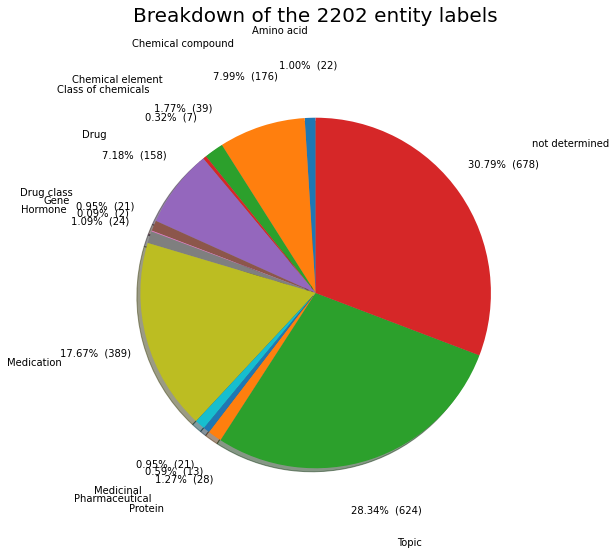

In [ ]:
plt.rcParams["figure.figsize"] = (7,7)

# The slices of the pie chart are ordered and plotted counter-clockwise
labels = labels_and_label_count_df['entity label']
counts = labels_and_label_count_df['entity label count']
total_entities = counts.sum()

def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return autopct

fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct=make_autopct(counts), 
        shadow=True, startangle=90, pctdistance=1.3, labeldistance=1.5)
ax1.axis('equal')

plt.title('Breakdown of the {0} entity labels'.format(total_entities), fontsize=20, y=1.2)

plt.show()

# Creating a dataframe with only the known data (without the 'not determined' label)

In [8]:
known_data_df = entities_df.loc[entities_df['entity label'].isin(important_types[:-1])].reset_index(drop=True) # All but 'not determined'
known_data_df

,entities,entity counts,entity label
0,hydroxychloroquine,1367,Medication
1,hcq,970,Medication
2,oxygen,802,Chemical element
3,tocilizumab,740,Drug
4,remdesivir,647,Medication
...,...,...,...
1519,dihydropyridine calcium,1,Topic
1520,carbon,1,Chemical element
1521,na,1,Chemical element
1522,patients.tocilizumab,1,Drug


# Creating a dataframe with only the chemicals and medicines

In [10]:
chems_meds_list = ['Chemical compound', 'Class of chemicals', 'Chemical element', 'Drug', 'Drug class', 'Pharmaceutical', 'Medication', 'Medicinal']
chem_med_data_df = known_data_df.loc[known_data_df['entity label'].isin(chems_meds_list)].reset_index(drop=True)
chem_med_data_df

,entities,entity counts,entity label
0,hydroxychloroquine,1367,Medication
1,hcq,970,Medication
2,oxygen,802,Chemical element
3,tocilizumab,740,Drug
4,remdesivir,647,Medication
...,...,...,...
819,hydroxychloroquine-sulfate,1,Drug
820,carbon,1,Chemical element
821,na,1,Chemical element
822,patients.tocilizumab,1,Drug


# Creating a dataframe with only the pathway related entities

In [9]:
pathway_related_list = ['Gene', 'Protein', 'Amino acid', 'Hormone']
pathway_related_data_df = known_data_df.loc[known_data_df['entity label'].isin(pathway_related_list)].reset_index(drop=True)
pathway_related_data_df

,entities,entity counts,entity label
0,melatonin,78,Hormone
1,aspartate,60,Amino acid
2,alanine,56,Amino acid
3,serine,39,Amino acid
4,bradykinin,23,Protein
...,...,...,...
71,3' hydroxyl,1,Protein
72,catechol-o-methyl,1,Protein
73,tnf alpha,1,Protein
74,glutamine,1,Amino acid


# Creating a dataframe with only the 'unknown' data (only the label 'not determined')

In [ ]:
unknown_data_df = entities_df.loc[entities_df['entity label'].isin([important_types[-1]])].reset_index(drop=True) # Only 'not determined'
unknown_data_df.to_csv('new_data.csv', index=False)
unknown_data_df

,entities,entity counts,entity label
0,lopinavir/ritonavir,297,not determined
1,lpv/r,111,not determined
2,astragaloside iv,8,not determined
3,hcqpa,7,not determined
4,hydroxychloroquine sulphate,7,not determined
...,...,...,...
673,crd42020182373,1,not determined
674,trimethoprim/sulfamethoxazole,1,not determined
675,crd42020209059,1,not determined
676,azithromicin,1,not determined
